# Класс Research: эксперименты с пайплайнами. Часть 1
Предназначен для многократного запуска одних и тех же пайплайнов с различными параметрами. Это могут быть параметры модели, параметры используемых аугментаций и даже сами модели.

### Пример использования

Рассмотрим простой пример: запуск пайплайнов vgg7_train и vgg7_test на MNIST с различными значениями layout. Для каждого значения layout пайплайны запускаются 10 раз, каждый раз обучаясь "с нуля" 100 итераций. На каждой итераций выполняется один прогон vgg7_train и vgg7_test. В vgg7_train запоминаются значения loss, в vgg7_test - accuracy.

In [1]:
import sys

sys.path.append('..')
sys.path.append('../..')

from radio.dataset import B, C, V, Config, F
from radio.dataset.opensets import MNIST
from radio.dataset.models.tf import VGG7

C:\Anaconda3\envs\tensorflow-gpu\lib\site-packages\dicom\__init__.py:53: UserWarning: 
This code is using an older version of pydicom, which is no longer 
maintained as of Jan 2017.  You can access the new pydicom features and API 
by installing `pydicom` from PyPI.
See 'Transitioning to pydicom 1.x' section at pydicom.readthedocs.org 
for more information.

  warnings.warn(msg)


In [2]:
import tensorflow as tf

model_config = {
    # 'device': '/gpu:1',
    'parameter': F(lambda batch: batch.images[0].shape),
    'session/config': tf.ConfigProto(gpu_options=tf.GPUOptions(per_process_gpu_memory_fraction=0.5,
                                                               allow_growth=True),
                                    allow_soft_placement=True),
    'inputs/images': {
        'shape': (28, 28, 1),
        'type': 'float32',
        'name': 'reshaped_images'
    },
    'inputs/labels': {
        'classes': 10,
        'type': 'int32',
        'transform': 'ohe',
        'name': 'targets'
    },
    'input_block/inputs': 'images',
    'output/ops': ['accuracy'],
    'loss': 'ce',
    'optimizer': 'Adam'
}

feed_dict = {'images': B('images'),
             'labels': B('labels')}

Все параметры, которые мы хотим варьировать, должны быть заданы через config пайплайна, т.е. в пайплайне это параметр задаётся как C('parameter_name'). Поскольку мы хотим варьировать параметр конфигурации модели, весь model_config зададим в конфиге пайплайна:

In [3]:
pipeline_config = Config(model_config=model_config)

Config - это новый класс из dataset для удобной работы с вложенными словарями.

В init_model конфиг передадим как C('model_config'). Отметим, что сразу передать конфиг c {'layout': C('layout')} нельзя.

In [4]:
mnist = MNIST()

vgg7_train = (mnist.train.p
              .init_variable('loss', init_on_each_run=list)
              .init_model('dynamic', VGG7, 'model', C('model_config'))
              .train_model('model', feed_dict=feed_dict, fetches='loss', save_to=V('loss'), mode='a')
              .run(batch_size=100, shuffle=True, lazy=True)
             )

vgg7_test = (mnist.test.p
             .init_variable('accuracy', init_on_each_run=list)
             .import_model('model', C('import_model_from'))
             .predict_model('model', feed_dict=feed_dict, fetches='output_accuracy', save_to=V('accuracy'), mode='a')
             .run(batch_size=32, shuffle=True, n_epochs=1, lazy=True)
            )

DownloadingDownloading DownloadingDownloading   http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gzhttp://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gzhttp://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz
http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz


ExtractingExtractingExtractingExtracting    C:\Users\kozhevin\AppData\Local\Temp\t10k-labels-idx1-ubyte.gzC:\Users\kozhevin\AppData\Local\Temp\train-images-idx3-ubyte.gzC:\Users\kozhevin\AppData\Local\Temp\t10k-images-idx3-ubyte.gzC:\Users\kozhevin\AppData\Local\Temp\train-labels-idx1-ubyte.gz





In [5]:
from radio.dataset.research import Option, KV

p = KV('model_config/body/layout', 'layout')
grid_config = Option(p, ['cna', 'can'])

In [6]:
from radio.dataset.research import Research, SingleRunning

mr = (Research()
     .add_pipeline(vgg7_train, variables='loss', config=pipeline_config, name='train')
     .add_pipeline(vgg7_test, variables='accuracy', import_model_from='train', execute_for=[100-1, 200-1], run=True, name='test')
     .add_grid_config(grid_config)
     .run(n_reps=3, n_iters=200, n_jobs=1, model_per_preproc=[{'device': '/gpu:1'}], name='my_research'))

In [6]:
from radio.dataset.research import Stat

In [7]:
st = Stat('my_research_2')

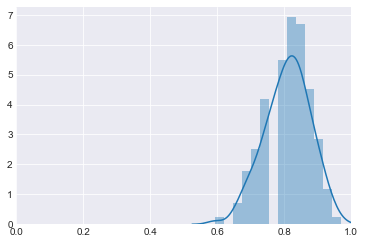

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

# sns.set_style("darkgrid")
sns.distplot(st.load_stat('layout_cna', 'test', 199)['test/accuracy'][0])
plt.xlim((0,1))
plt.show()

In [16]:
st.load_stat('layout_cna', 'test', 99)['test']

{'accuracy': [[0.28125,
   0.34375,
   0.3125,
   0.5625,
   0.4375,
   0.34375,
   0.21875,
   0.21875,
   0.40625,
   0.3125,
   0.4375,
   0.28125,
   0.34375,
   0.34375,
   0.375,
   0.34375,
   0.34375,
   0.1875,
   0.5,
   0.375,
   0.3125,
   0.21875,
   0.25,
   0.34375,
   0.3125,
   0.21875,
   0.28125,
   0.34375,
   0.1875,
   0.1875,
   0.34375,
   0.25,
   0.3125,
   0.34375,
   0.1875,
   0.3125,
   0.34375,
   0.28125,
   0.375,
   0.34375,
   0.28125,
   0.25,
   0.40625,
   0.1875,
   0.21875,
   0.4375,
   0.34375,
   0.25,
   0.21875,
   0.28125,
   0.3125,
   0.4375,
   0.28125,
   0.4375,
   0.25,
   0.1875,
   0.3125,
   0.3125,
   0.1875,
   0.40625,
   0.21875,
   0.375,
   0.4375,
   0.40625,
   0.25,
   0.3125,
   0.21875,
   0.3125,
   0.28125,
   0.21875,
   0.28125,
   0.21875,
   0.375,
   0.375,
   0.1875,
   0.125,
   0.21875,
   0.25,
   0.25,
   0.25,
   0.3125,
   0.40625,
   0.375,
   0.1875,
   0.28125,
   0.28125,
   0.25,
   0.3125,
   0.1875,


In [17]:
len(vgg7_test.indices) / 32

312.5

In [14]:
import dill
with open('my_research/results/layout_cna/0/final', 'rb') as file:
    res = dill.load(file)

In [15]:
res['test']

{'accuracy': [],
 'iterations': [0, 100, 200, 300, 400, 500, 600, 700, 800, 900]}

In [ ]:
grid = (op1 + op2) * op3
[item.config().flatten() for item in grid.gen_configs()]

In [ ]:
[item.alias() for item in grid.gen_configs()]

Теперь, когда у конфигов есть псевдонимы, мы можем получить удобное представление для конфигурций: